In [126]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

import torch.nn as nn
import torch
from torchinfo import summary

In [127]:
# Load CSV data
data = pd.read_csv('./data/keypoint.csv', header=None)
X_dataset = data.iloc[:, 1:].values  # Features: All columns except the first
#X_dataset = X_dataset[::4]
y_dataset = data[0].values  # Labels: The first column
#y_dataset = y_dataset[::4]

# Convert labels to integers (assuming the labels are string values, like 'A', 'B', etc.)
label_map = {label: idx for idx, label in enumerate(sorted(np.unique(y_dataset)))}
y_dataset_int = np.array([label_map[label] for label in y_dataset])

# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset_int, train_size=0.75, random_state=42)

# Standardize the features (important for neural networks)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Custom Dataset class
class HandLandmarksDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]
        return torch.tensor(sample, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

# Create Dataset objects for train and test data
train_dataset = HandLandmarksDataset(X_train_scaled, y_train)
test_dataset = HandLandmarksDataset(X_test_scaled, y_test)

# Create DataLoader objects for batching and shuffling
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [128]:
data[0].value_counts()

0
w    1616
u    1340
t    1228
q    1108
p    1092
l    1020
n    1008
a    1000
v     968
d     952
k     928
b     908
y     868
s     844
o     828
f     808
g     788
e     764
i     760
h     744
x     740
j     712
z     684
m     676
r     668
c     612
Name: count, dtype: int64

In [129]:
class MLP_ASL(nn.Module):
    def __init__(self, input_dim=42, num_classes=26):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(64, 26) # 26 classes, one for each possible letter in the alphabet
        )

    def forward(self, x):
        return self.model(x)

In [130]:
summary(MLP_ASL(), input_size=(32, 42)) #change 42 if number of inputs is changed

Layer (type:depth-idx)                   Output Shape              Param #
MLP_ASL                                  [32, 26]                  --
├─Sequential: 1-1                        [32, 26]                  --
│    └─Linear: 2-1                       [32, 256]                 11,008
│    └─BatchNorm1d: 2-2                  [32, 256]                 512
│    └─ReLU: 2-3                         [32, 256]                 --
│    └─Dropout: 2-4                      [32, 256]                 --
│    └─Linear: 2-5                       [32, 128]                 32,896
│    └─BatchNorm1d: 2-6                  [32, 128]                 256
│    └─ReLU: 2-7                         [32, 128]                 --
│    └─Dropout: 2-8                      [32, 128]                 --
│    └─Linear: 2-9                       [32, 64]                  8,256
│    └─ReLU: 2-10                        [32, 64]                  --
│    └─Dropout: 2-11                     [32, 64]                  --
│ 

In [131]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP_ASL().to(DEVICE)

In [132]:
model

MLP_ASL(
  (model): Sequential(
    (0): Linear(in_features=42, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=128, out_features=64, bias=True)
    (9): ReLU()
    (10): Dropout(p=0.2, inplace=False)
    (11): Linear(in_features=64, out_features=26, bias=True)
  )
)

In [133]:
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=1e-3)  # Adam optimizer is often more efficient
criterion = nn.CrossEntropyLoss()  # CrossEntropyLoss for multi-class classification

In [134]:
import torch
from torch.utils.data import DataLoader
from torch._prims_common import DeviceLikeType


def fit(
    model: torch.nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    device: DeviceLikeType,
    optimizer: torch.optim.Optimizer,
    criterion: torch.nn.Module,
    num_epochs: int,
    flatten: bool = True,
) -> tuple[torch.nn.Module, dict[str, list]]:
    """
    Trains and validates a PyTorch neural network model.

    Args:
        model (torch.nn.Module): The neural network model to be trained.
        train_loader (DataLoader): DataLoader for the training dataset. It provides batches of data.
        val_loader (DataLoader): DataLoader for the validation dataset. It provides batches of data.
        device (DeviceLikeType): The device to run the training (e.g., 'cpu' or 'cuda').
        optimizer (torch.optim.Optimizer): Optimizer to update the model's parameters based on the gradients.
        criterion (torch.nn.Module): The loss function to compute the error between predictions and true labels.
        num_epochs (int): Number of epochs (full passes through the training data) to train the model.
        flatten (bool): Whether to flatten input tensors to 1D. Useful for feedforward networks. Default is False.

    Returns:
        Dict[str, list]: A dictionary containing training and validation loss and accuracy histories:
            - 'train_loss': List of training losses for each epoch.
            - 'val_loss': List of validation losses for each epoch.
            - 'train_acc': List of training accuracies for each epoch.
            - 'val_acc': List of validation accuracies for each epoch.

    Notes:
        This function alternates between training and validation phases:
        1. During the training phase, the model is updated using backpropagation and gradient descent.
        2. During the validation phase, the model's performance is evaluated without updating parameters.
        Metrics for each phase are printed for every epoch.

    Example Usage:
        train_history = fit(
            model=my_model,
            train_loader=my_train_loader,
            val_loader=my_val_loader,
            device='cuda',
            optimizer=my_optimizer,
            criterion=torch.nn.CrossEntropyLoss(),
            num_epochs=10
        )
    """
    # Initialize history trackers
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    for epoch in range(num_epochs):
        #################
        # TRAINING PHASE
        #################

        model.train()  # Set the model to training mode

        train_loss = 0.0  # Accumulate the training loss
        correct = 0  # Count of correctly predicted samples
        total = 0  # Total number of samples

        for (
            images,
            labels,
        ) in train_loader:  # Loop through batches in the training dataset
            # Move data to the selected device (CPU or GPU)
            images, labels = images.to(device), labels.to(device)

            # Flatten the images into 1D vectors (if necessary for fully connected layers)
            if flatten:
                images = images.view(images.size(0), -1)

            # Forward pass: Compute model outputs and loss
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass: Compute gradients
            optimizer.zero_grad()  # Clear previous gradients
            loss.backward()  # Compute new gradients

            # Update model parameters
            optimizer.step()

            # Accumulate loss and accuracy metrics
            train_loss += loss.item() * images.size(0)  # Loss multiplied by batch size
            _, predicted = torch.max(outputs, 1)  # Get predicted class
            total += labels.size(0)  # Update total number of samples
            correct += (predicted == labels).sum().item()  # Count correct predictions

        # Calculate average training loss and accuracy
        train_loss /= len(train_loader.dataset)
        train_accuracy = 100 * correct / total

        ###################
        # VALIDATION PHASE
        ###################

        model.eval()  # Set the model to evaluation mode
        val_loss = 0.0  # Accumulate validation loss
        correct = 0
        total = 0

        with torch.no_grad():  # No gradients needed during validation
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                if flatten:
                    images = images.view(images.size(0), -1)

                outputs = model(images)  # Forward pass
                loss = criterion(outputs, labels)  # Compute loss

                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        # Calculate average validation loss and accuracy
        val_loss /= len(val_loader.dataset)
        val_accuracy = 100 * correct / total

        # Save metrics to history
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_accuracy)
        history["val_acc"].append(val_accuracy)

        # Print progress for the current epoch
        print(
            f"Epoch [{epoch+1}/{num_epochs}]: "
            f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy:.2f}% | "
            f"Val Loss: {val_loss:.4f} | Val Accuracy: {val_accuracy:.2f}%"
        )

    return model, history

In [135]:
model, history = fit(
    model,
    train_loader = train_loader,
    val_loader = test_loader,
    device = DEVICE,
    optimizer = optimizer,
    criterion = criterion,
    num_epochs = 150
)

Epoch [1/150]: Train Loss: 1.7705 | Train Accuracy: 47.54% | Val Loss: 0.5871 | Val Accuracy: 85.62%
Epoch [2/150]: Train Loss: 0.6058 | Train Accuracy: 79.75% | Val Loss: 0.2885 | Val Accuracy: 90.96%
Epoch [3/150]: Train Loss: 0.4204 | Train Accuracy: 85.79% | Val Loss: 0.1959 | Val Accuracy: 94.13%
Epoch [4/150]: Train Loss: 0.3234 | Train Accuracy: 89.36% | Val Loss: 0.1500 | Val Accuracy: 94.96%
Epoch [5/150]: Train Loss: 0.2822 | Train Accuracy: 90.73% | Val Loss: 0.1138 | Val Accuracy: 96.60%
Epoch [6/150]: Train Loss: 0.2444 | Train Accuracy: 92.12% | Val Loss: 0.0931 | Val Accuracy: 97.31%
Epoch [7/150]: Train Loss: 0.2177 | Train Accuracy: 93.18% | Val Loss: 0.0816 | Val Accuracy: 97.55%
Epoch [8/150]: Train Loss: 0.1933 | Train Accuracy: 93.64% | Val Loss: 0.0745 | Val Accuracy: 97.75%
Epoch [9/150]: Train Loss: 0.1759 | Train Accuracy: 94.32% | Val Loss: 0.0655 | Val Accuracy: 98.28%
Epoch [10/150]: Train Loss: 0.1688 | Train Accuracy: 94.47% | Val Loss: 0.0607 | Val Accura

In [136]:
import matplotlib.pyplot as plt
def plot_training_history(history):
    """
    Plots the training and validation losses and accuracies from the history dictionary.

    Args:
        history (dict): A dictionary containing training history with keys:
                        - 'train_loss': List of training losses.
                        - 'val_loss': List of validation losses.
                        - 'train_acc': List of training accuracies.
                        - 'val_acc': List of validation accuracies.
    """
    epochs = range(1, len(history["train_loss"]) + 1)

    # Plot Losses
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)  # Create a subplot for losses
    plt.plot(epochs, history["train_loss"], label="Train Loss", marker="o")
    plt.plot(epochs, history["val_loss"], label="Validation Loss", marker="o")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.grid(True)

    # Plot Accuracies
    plt.subplot(1, 2, 2)  # Create a subplot for accuracies
    plt.plot(epochs, history["train_acc"], label="Train Accuracy", marker="o")
    plt.plot(epochs, history["val_acc"], label="Validation Accuracy", marker="o")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.title("Training and Validation Accuracy")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

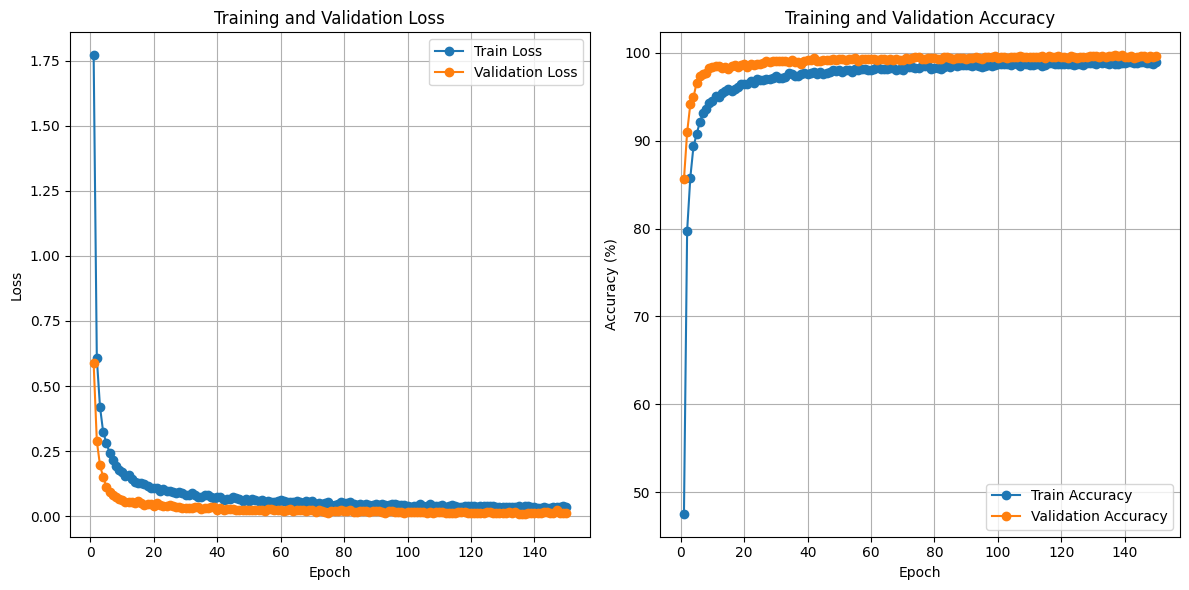

In [137]:
plot_training_history(history)

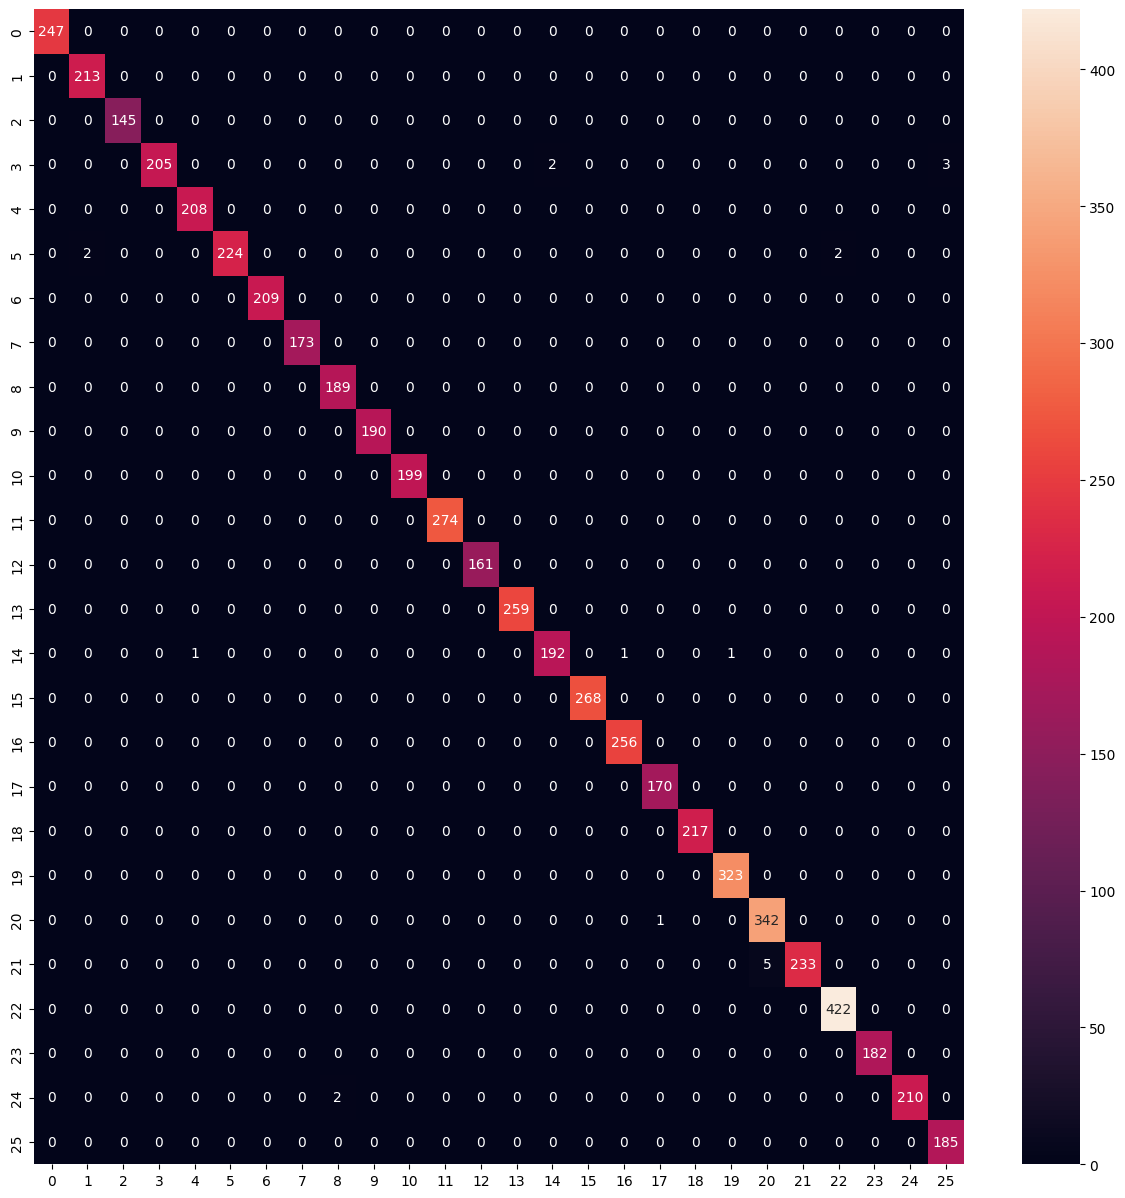

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       247
           1       0.99      1.00      1.00       213
           2       1.00      1.00      1.00       145
           3       1.00      0.98      0.99       210
           4       1.00      1.00      1.00       208
           5       1.00      0.98      0.99       228
           6       1.00      1.00      1.00       209
           7       1.00      1.00      1.00       173
           8       0.99      1.00      0.99       189
           9       1.00      1.00      1.00       190
          10       1.00      1.00      1.00       199
          11       1.00      1.00      1.00       274
          12       1.00      1.00      1.00       161
          13       1.00      1.00      1.00       259
          14       0.99      0.98      0.99       195
          15       1.00      1.00      1.00       268
          16       1.00      1.00      1.00       256
     

In [138]:
def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    # Convert the confusion matrix to a DataFrame for better visualization
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    # Plot the confusion matrix as a heatmap
    fig, ax = plt.subplots(figsize=(15, 15))
    sns.heatmap(df_cmx, annot=True, fmt='g', square=False)
    ax.set_ylim(len(set(y_true)), 0)  # To ensure proper y-axis limits
    plt.show()
    
    # Print the classification report (optional)
    if report:
        print('Classification Report')
        print(classification_report(y_true, y_pred))

# Assuming your validation data is in a DataLoader (e.g., val_loader)
model.eval()  # Set the model to evaluation mode
y_true = []  # True labels
y_pred = []  # Predicted labels

with torch.no_grad():  # No need to compute gradients during evaluation
    for images, labels in test_loader:  # val_loader is the DataLoader for validation data
        images, labels = images.to(DEVICE), labels.to(DEVICE)  # Move data to GPU or CPU
        
        # Forward pass
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)  # Get the index of the highest probability

        # Append true labels and predicted labels to the lists
        y_true.extend(labels.cpu().numpy())  # Convert to CPU and then to numpy for further processing
        y_pred.extend(predicted.cpu().numpy())

# After the loop, y_true and y_pred will hold the entire dataset's labels
print_confusion_matrix(y_true, y_pred)


In [139]:
# Set the model to evaluation mode
model.eval()

# Create a dummy input tensor with the correct input size
dummy_input = torch.randn(1, 42)  # Adjust the size as needed

# Trace the model
traced_model = torch.jit.trace(model, dummy_input)

# Save the traced model
traced_model.save('./data/keypoint_classifier.pt')